In [1]:
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# colormap that matplotlib can undeerstand based on the figure colors
cmap = ListedColormap(["#e68193", "#c68847", "#9e9241", "#759c40", "#43a178", "#44948e", "#4a9eb4", "#7fa0e4", "#c789e5", "#e377c5"])

## CHANGE THIS!!!!
# read csv geospatial data 
gdf = gpd.read_file('/home/sghos1/Desktop/coding_sprint/attiki_municipalities.shp')

# reproject to wgs84
gdf = gdf.to_crs(epsg=4326)



# add savings data
savings = pd.read_csv('/home/sghos1/Desktop/coding_sprint/adequacy.csv')

gdf["KWD_YPES"] = gdf["KWD_YPES"].astype(int)
savings["KWD_YPES"] = savings["KWD_YPES"].astype(int)

# join tables
merged = gdf.merge(savings, on="KWD_YPES")

In [2]:
!pip install openpyxl


Defaulting to user installation because normal site-packages is not writeable


In [3]:
import pandas as pd

pd.ExcelFile('/home/sghos1/Downloads/Athens.xlsx').sheet_names

main_data = pd.read_excel('/home/sghos1/Downloads/Athens.xlsx', sheet_name='Final')


In [4]:
# create few consistent indicators such energy consumptions per households (already present)
# energy cost per household (energy cost per resident * nos of resident per buildings)
# annual income per household (already present)
main_data['Energy cost per household'] = main_data['Energy cost per residents'] * main_data['Residents per building']

# Step 4: Calculate the Energy Poverty Index (EPI)
# Formula: EPI = (Energy Cost per Resident (eur) / Average Annual Income per Household (eur)) * 100

main_data['Energy Poverty Household'] = (main_data['Energy cost per household'] / main_data['annual income per household']) * 100
main_data['Energy Poverty Threshold'] =main_data['annual income per household']*.10

main_data['Energy_Poverty_Household_s10'] = (main_data['Energy cost per household']*0.90 / main_data['annual income per household']) * 100

main_data['Energy_Poverty_improvement'] =  main_data['Energy_Poverty_Household_s10']-main_data['Energy Poverty Household']

In [5]:
# join tables
merged = gdf.merge(main_data, on="KWD_YPES")
main_data.head(5)

,NAME,Περιφερειακή ενότητα,KWD_YPES,buildings,Area,Pop Dens,PV Production Gwh – Only BBE,BBE SC1_100 – Consumption GWh,Adequacy,Population,...,Energy consumption per household Mwh 4 residents,Consumption Mwh per building,Energy cost per residents,Average,annual income per household,Energy cost per household,Energy Poverty Household,Energy Poverty Threshold,Energy_Poverty_Household_s10,Energy_Poverty_improvement
0,Dafni – Imittos,Κεντρική Αττική,9189,6040,2.4,14119.166670,28.438429,92.682110,0.306838,33886,...,10.940460,15.344720,272.007195,Average,32114,1526.032420,4.751923,3211.4,4.276730,-0.475192
1,Agia Varbara,Δυτική Αττική,9179,4908,2.4,11149.583330,26.721555,27.255805,0.980399,26759,...,4.074264,5.553342,101.296378,Average,28262,552.279905,1.954143,2826.2,1.758729,-0.195414
2,Nea Smyrni,Νότια Αττική,9200,5895,3.5,20815.142860,38.941916,253.013508,0.153912,72853,...,13.891728,42.920018,345.383078,Average,31011,4268.395828,13.764135,3101.1,12.387721,-1.376413
3,Filadelphia,Κεντρική Αττική,9193,3824,3.7,9448.108108,25.052255,87.689008,0.285694,34958,...,10.033641,22.931226,249.461407,Average,31634,2280.510421,7.209049,3163.4,6.488144,-0.720905
4,Vrilissia,Βόρεια Αττική,9169,3595,3.9,8312.051282,33.345475,93.125557,0.358070,32417,...,11.490953,25.904188,285.693824,Average,29857,2576.171538,8.628367,2985.7,7.765530,-0.862837


In [6]:
merged["Sav_100"]=savings["S"]
merged["Sav_10"]=savings["S10"]

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_188082/3043752026.py:239: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


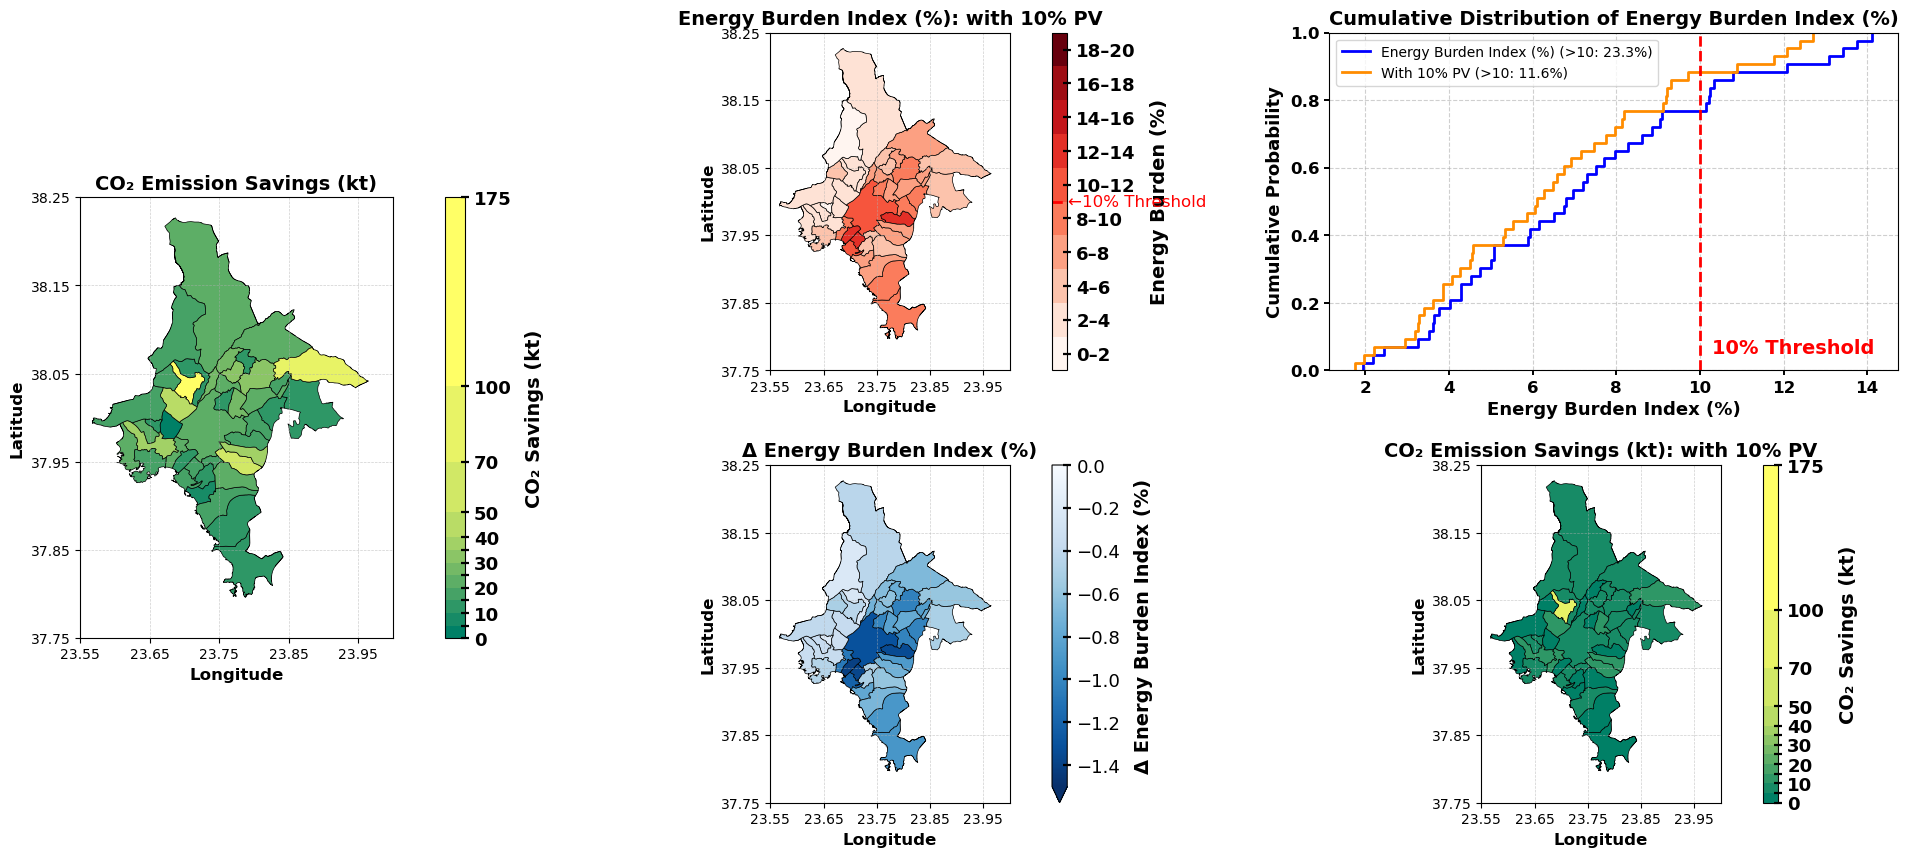

In [7]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import BoundaryNorm
from matplotlib import cm, colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colorbar as cbar
import numpy as np

# -------------------------
# Common settings & helpers
# -------------------------
# CO₂ savings shared bin edges
BIN_EDGES_CO2 = [0, 5, 10, 15, 20, 25, 30, 35, 40, 50, 70, 100, 175]
# Energy burden bin edges (0, 2, ..., 20)
BIN_EDGES_EB = list(range(0, 22, 2))

# Fixed bounding box (Athens)
LON_MIN, LON_MAX = 23.55, 24.00
LAT_MIN, LAT_MAX = 37.75, 38.25
XTICKS = np.arange(LON_MIN, LON_MAX + 0.0001, 0.1)
YTICKS = np.arange(LAT_MIN, LAT_MAX + 0.0001, 0.1)

def add_discrete_map(
    ax, gdf, column,
    cmap_name="summer",
    bin_edges=BIN_EDGES_CO2,
    title="",
    cbar_label="",
    cbar_tick_mode="ranges",        # "ranges" (Energy Burden) or "edges" (CO₂)
    cbar_edge_labels_subset=None,   # set of edge values to label; others blank (only for "edges")
    cbar_threshold=None,            # numeric threshold to annotate on colorbar (only for "ranges")
    cbar_threshold_label=None       # text label for the threshold
):
    """Plot a GeoDataFrame column with non-uniform bins and add a proportional colorbar."""
    n_bins_local = len(bin_edges) - 1
    norm = BoundaryNorm(bin_edges, n_bins_local, clip=True)
    cmap = cm.get_cmap(cmap_name, n_bins_local)

    gdf.plot(
        column=column,
        cmap=cmap,
        edgecolor="black",
        linewidth=0.5,
        norm=norm,
        ax=ax,
    )

    # --- Colorbar beside the axis ---
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    if cbar_tick_mode == "edges":
        cb = cbar.ColorbarBase(
            cax,
            cmap=cmap,
            norm=norm,
            boundaries=bin_edges,
            ticks=bin_edges,                # ticks at every edge
            spacing="proportional",
            orientation="vertical",
            label=cbar_label
        )
        # Sparse edge labels to avoid clutter
        if cbar_edge_labels_subset is None:
            cbar_edge_labels_subset = {0, 10, 20, 30, 40, 50, 70, 100, 175}
        ticklabels = [str(b) if b in cbar_edge_labels_subset else "" for b in bin_edges]
        cb.ax.set_yticklabels(ticklabels, fontsize=13, fontweight="bold")
        cb.ax.tick_params(width=1.6, length=6, direction="inout")

    else:  # "ranges"
        cb = cbar.ColorbarBase(
            cax,
            cmap=cmap,
            norm=norm,
            boundaries=bin_edges,
            ticks=[(a+b)/2 for a, b in zip(bin_edges[:-1], bin_edges[1:])],
            spacing="proportional",
            orientation="vertical",
            label=cbar_label
        )
        cb.ax.set_yticklabels(
            [f"{a}–{b}" for a, b in zip(bin_edges[:-1], bin_edges[1:])],
            fontsize=13, fontweight="bold"
        )
        cb.ax.tick_params(width=1.6, length=6, direction="inout")

        # --- Threshold marker on colorbar (drawn in DATA coords) ---
        if cbar_threshold is not None:
            # Draw the line at the data value (no transform kw allowed)
            cb.ax.axhline(y=cbar_threshold, color='red', linestyle='--', linewidth=2)

            # Label positioned using axes-fraction coords for robust placement
            min_val, max_val = bin_edges[0], bin_edges[-1]
            y_frac = (cbar_threshold - min_val) / (max_val - min_val)
            if cbar_threshold_label:
                cb.ax.text(
                    1.05, y_frac, cbar_threshold_label,
                    color='red', fontsize=12,
                    va='center', ha='left',
                    transform=cb.ax.transAxes
                )

    # Bold, larger colorbar label
    cb.set_label(cbar_label, fontsize=14, fontweight="bold", labelpad=10)

    # --- Axes formatting ---
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_xlabel("Longitude", fontsize=12, fontweight="bold")
    ax.set_ylabel("Latitude", fontsize=12, fontweight="bold")
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
    ax.set_xlim(LON_MIN, LON_MAX)
    ax.set_ylim(LAT_MIN, LAT_MAX)
    ax.set_xticks(XTICKS)
    ax.set_yticks(YTICKS)

def add_continuous_map(
    ax, gdf, column,
    vmin, vmax,
    cmap_name="Blues_r",
    title="", cbar_label="", extend=None
):
    """Plot a continuous map with Normalize and add a colorbar."""
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)

    gdf.plot(
        column=column,
        cmap=cmap,
        edgecolor="black",
        linewidth=0.5,
        vmin=vmin, vmax=vmax,
        ax=ax,
    )

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cb = plt.colorbar(sm, cax=cax, orientation="vertical", extend=extend)

    cb.ax.tick_params(labelsize=13, width=1.6, length=6, direction="inout")
    cb.set_label(cbar_label, fontsize=14, fontweight="bold", labelpad=10)

    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_xlabel("Longitude", fontsize=12, fontweight="bold")
    ax.set_ylabel("Latitude", fontsize=12, fontweight="bold")
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
    ax.set_xlim(LON_MIN, LON_MAX)
    ax.set_ylim(LAT_MIN, LAT_MAX)
    ax.set_xticks(XTICKS)
    ax.set_yticks(YTICKS)

# -------------------------
# Figure layout
# -------------------------
fig = plt.figure(figsize=(24, 10))
outer = fig.add_gridspec(1, 2, width_ratios=[1, 3], wspace=0.18)

# Left: 1/4 width — Sav_100 (CO₂ savings, edge ticks with sparse labels)
ax_left = fig.add_subplot(outer[0, 0])
add_discrete_map(
    ax_left, merged, "Sav_100",
    cmap_name="summer",
    bin_edges=BIN_EDGES_CO2,
    title="CO₂ Emission Savings (kt)",
    cbar_label="CO₂ Savings (kt)",
    cbar_tick_mode="edges",
    cbar_edge_labels_subset={0, 10, 20, 30, 40, 50, 70, 100, 175}
)

# Right: 3/4 width -> 2x2 subgrid
right = outer[0, 1].subgridspec(2, 2, hspace=0.28, wspace=0.25)

# (1,1): Energy Burden with 10% PV — ranges labels + threshold marker on colorbar
ax_11 = fig.add_subplot(right[0, 0])
add_discrete_map(
    ax_11, merged, "Energy_Poverty_Household_s10",
    cmap_name="Reds",
    bin_edges=BIN_EDGES_EB,
    title="Energy Burden Index (%): with 10% PV",
    cbar_label="Energy Burden (%)",
    cbar_tick_mode="ranges",
    cbar_threshold=10,                         # draw dashed line at 10 on the colorbar
    cbar_threshold_label="←10% Threshold"      # red label next to it
)

# (1,2): CDF with bold ticks
ax_12 = fig.add_subplot(right[0, 1])
x1 = pd.to_numeric(merged["Energy Poverty Household"], errors="coerce")
x2 = pd.to_numeric(merged["Energy_Poverty_Household_s10"], errors="coerce")
x1 = x1[np.isfinite(x1)]
x2 = x2[np.isfinite(x2)]
n1 = max(x1.size, 1); n2 = max(x2.size, 1)
p1 = round((x1 > 10).sum() / n1 * 100, 1)
p2 = round((x2 > 10).sum() / n2 * 100, 1)

sns.ecdfplot(x=x1, ax=ax_12, color="blue", linewidth=2,
             label=f"Energy Burden Index (%) (>10: {p1}%)")
sns.ecdfplot(x=x2, ax=ax_12, color="darkorange", linewidth=2,
             label=f"With 10% PV (>10: {p2}%)")

ax_12.axvline(x=10, color="red", linestyle="--", linewidth=2)
ax_12.text(10.3, 0.05, "10% Threshold", color="red", fontsize=14, fontweight="bold")

ax_12.set_xlabel("Energy Burden Index (%)", fontsize=13, fontweight="bold")
ax_12.set_ylabel("Cumulative Probability", fontsize=13, fontweight="bold")
ax_12.set_title("Cumulative Distribution of Energy Burden Index (%)", fontsize=14, fontweight="bold")
ax_12.tick_params(axis='both', labelsize=12, width=1.4)
for label in ax_12.get_xticklabels() + ax_12.get_yticklabels():
    label.set_fontweight('bold')
ax_12.grid(True, linestyle="--", alpha=0.6)
ax_12.legend(fontsize=10, loc="upper left")

# (2,1): Δ Energy_Poverty_improvement (continuous)
ax_21 = fig.add_subplot(right[1, 0])
add_continuous_map(
    ax_21, merged, "Energy_Poverty_improvement",
    vmin=-1.5, vmax=0.0,
    cmap_name="Blues_r",
    title="Δ Energy Burden Index (%)",
    cbar_label="Δ Energy Burden Index (%)",
    extend="min"
)

# (2,2): Sav_10 — CO₂ savings, edge ticks with sparse labels
ax_22 = fig.add_subplot(right[1, 1])
add_discrete_map(
    ax_22, merged, "Sav_10",
    cmap_name="summer",
    bin_edges=BIN_EDGES_CO2,
    title="CO₂ Emission Savings (kt): with 10% PV",
    cbar_label="CO₂ Savings (kt)",
    cbar_tick_mode="edges",
    cbar_edge_labels_subset={0, 10, 20, 30, 40, 50, 70, 100, 175}
)

plt.tight_layout()
plt.show()
